In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from tensorflow.keras.utils import plot_model

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Read Data

In [4]:
path = '/content/drive/MyDrive/Proyecto Desarrollo en Aplicaciones con Visión Artificial/Sergio Borrador'
x_train = np.load(path + '/x_train.npy')
x_test = np.load(path + '/x_test.npy')
x_val = np.load(path + '/x_val.npy')

y_train = np.load(path + '/y_train.npy')
y_test = np.load(path + '/y_test.npy')
y_val = np.load(path + '/y_val.npy')

print(x_train.shape, 
      x_test.shape,
      x_val.shape, 
      y_train.shape, 
      y_test.shape, 
      y_val.shape)

(9941, 75, 75, 3) (2762, 75, 75, 3) (1105, 75, 75, 3) (9941,) (2762,) (1105,)


# CNN

In [5]:
def create_model(input_shape, fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    conv_base.trainable = True
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)

    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1024, activation='relu',
                      kernel_initializer='he_normal')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(16, activation='relu',
                      kernel_initializer='he_normal')(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer = Adam(learning_rate=0.001), 
           loss = "binary_crossentropy", 
           metrics = ['accuracy'])
    
    return model

In [6]:
input_shape = (75, 75, 3)
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, fine_tune=0)
vgg_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                              

## Plot Network

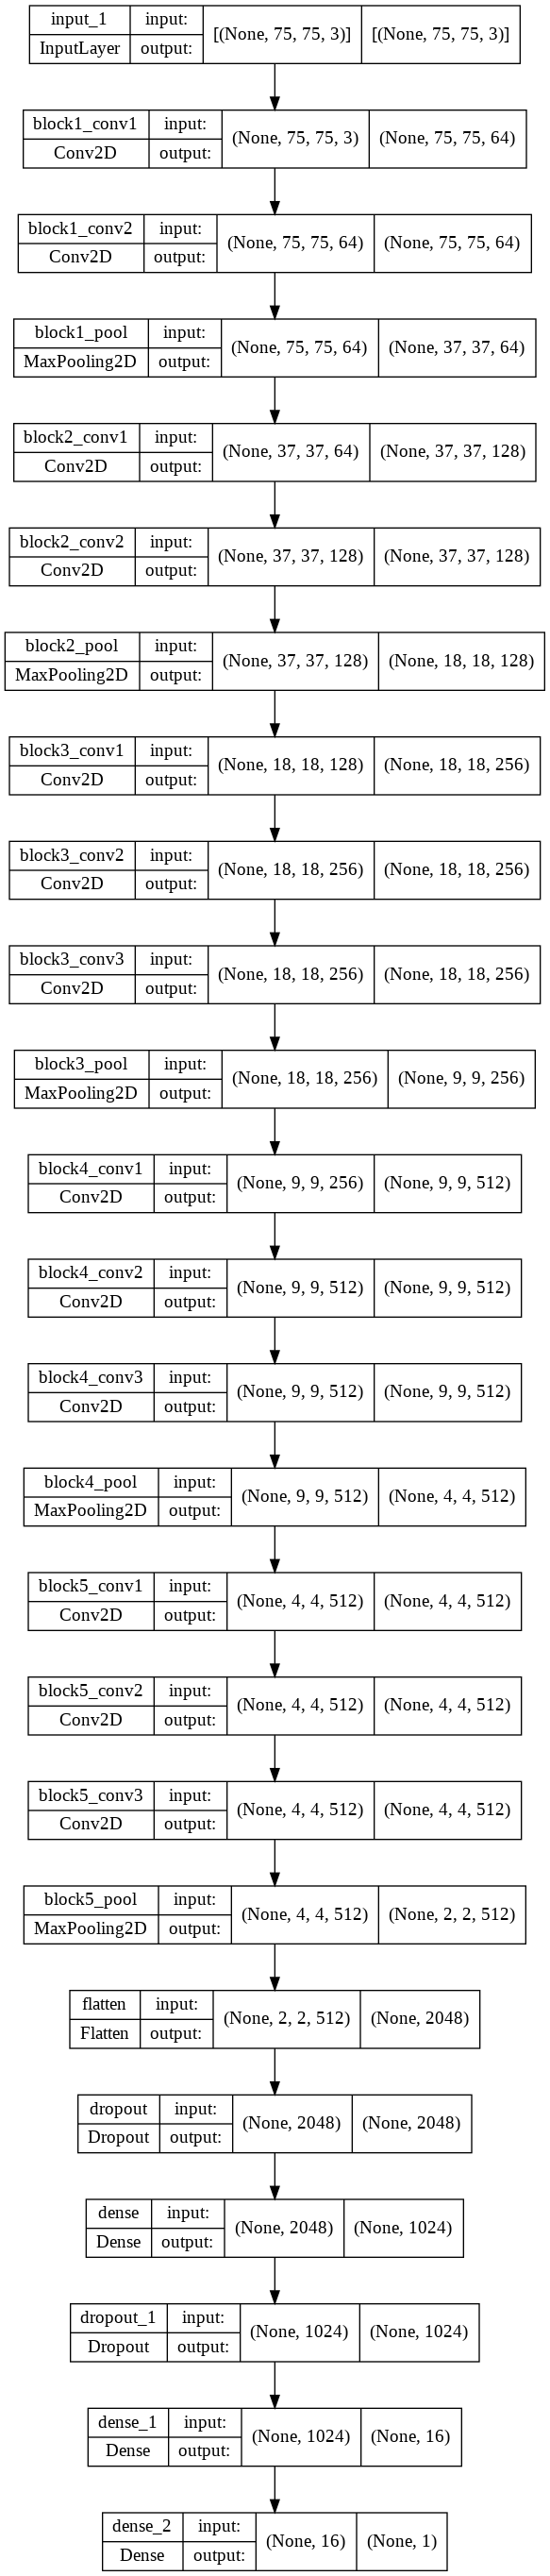

In [7]:
plot_model(vgg_model, to_file="./TL_Vgg.png", show_shapes=True)

# Train

In [8]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                      mode = 'min', 
                                      verbose = 1, 
                                      patience = 10)

#tf.random.set_seed(42)
history = vgg_model.fit(x_train, y_train, 
                        epochs = 60, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/60
39/39 [==============================] - 43s 608ms/step - loss: 0.8731 - accuracy: 0.7197 - val_loss: 0.5863 - val_accuracy: 0.7321
Epoch 2/60
39/39 [==============================] - 16s 415ms/step - loss: 0.6017 - accuracy: 0.7308 - val_loss: 0.5730 - val_accuracy: 0.7321
Epoch 3/60
39/39 [==============================] - 16s 419ms/step - loss: 0.5296 - accuracy: 0.7379 - val_loss: 0.5131 - val_accuracy: 0.7321
Epoch 4/60
39/39 [==============================] - 16s 422ms/step - loss: 0.4654 - accuracy: 0.7435 - val_loss: 0.4674 - val_accuracy: 0.7312
Epoch 5/60
39/39 [==============================] - 17s 424ms/step - loss: 0.4589 - accuracy: 0.7584 - val_loss: 0.4544 - val_accuracy: 0.7475
Epoch 6/60
39/39 [==============================] - 17s 426ms/step - loss: 0.4165 - accuracy: 0.7927 - val_loss: 0.4052 - val_accuracy: 0.8109
Epoch 7/60
39/39 [==============================] - 17s 431ms/step - loss: 0.3694 - accuracy: 0.8303 - val_loss: 0.4394 - val_accuracy: 0.7928

In [9]:
yp_train = vgg_model.predict(x_train)
yp_val = vgg_model.predict(x_val)
yp_test = vgg_model.predict(x_test)

In [10]:
yp_train = np.rint(yp_train)
yp_val = np.rint(yp_val)
yp_test = np.rint(yp_test)

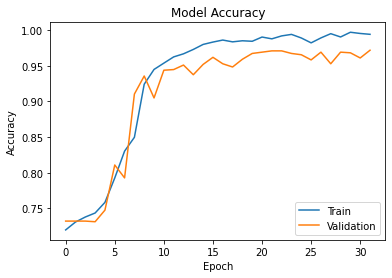

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

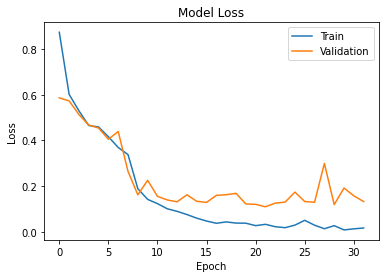

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

In [13]:
def evaluacion_metricas(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7350
           1       0.98      1.00      0.99      2591

    accuracy                           1.00      9941
   macro avg       0.99      1.00      0.99      9941
weighted avg       1.00      1.00      1.00      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.9988
Specificity on Train Data:  0.9943
Accuracy on Train Data:  0.9955
Precision on Train Data:  0.984
F1 Score on Train Data:  0.9914
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       809
           1       0.93      0.97      0.95       296

    accuracy                 

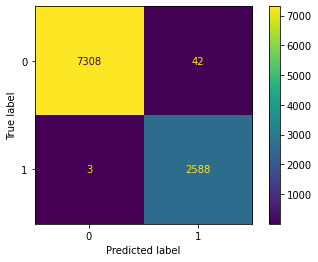

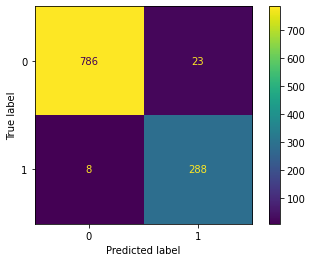

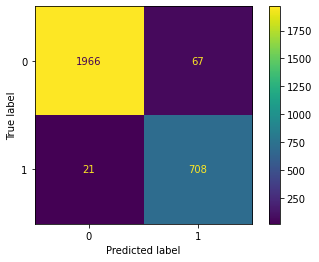

In [14]:
evaluacion_metricas("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)